In [47]:
%matplotlib inline

import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import matplotlib.colors as col
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
import matplotlib.path as mpath
import cosima_cookbook as cc
import cmocean.cm as cmocean
import cmocean.cm as cm
from collections import OrderedDict
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import os # operating system interface
from os.path import expanduser

import warnings
warnings.filterwarnings('ignore')
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

In [48]:
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/39529/status,
Dashboard: /proxy/39529/status,Workers: 4
Total threads: 8,Total memory: 200.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36211,Workers: 4
Dashboard: /proxy/39529/status,Total threads: 8
Started: Just now,Total memory: 200.00 GiB
Comm: tcp://127.0.0.1:36115,Total threads: 2
Dashboard: /proxy/40311/status,Memory: 50.00 GiB
Nanny: tcp://127.0.0.1:41005,


In [49]:
lat_slice  = slice(-80,-20)

In [50]:
# topography data for plotting:
#extract the MOM model grid info - 50 and 75 vertical levels
hgrid_file ='/g/data/v45/pas561/mom/archive/mom01_unmasked_ocean_grid.nc'
vgrid_file ='/g/data/v45/pas561/mom/archive/VertOverturn/kds75.uvwt.230-257.ncra.nc'

# Extract the variables
nc = xr.open_dataset(hgrid_file) # file handle, open in read only mode
geolon_t = nc.geolon_t
geolat_t = nc.geolat_t
area_t = nc.area_t
dxt = nc.dxt
dyt = nc.dyt
kmt = nc.kmt
ht = nc.ht
print(geolon_t.shape)

ht = ht.sel(yt_ocean=lat_slice)
ht = ht.load()
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)
# make land go all the way to -90S:
land_mask_lat = ht.yt_ocean.values
land_mask_lat[0] = -90

fontsize=13

(2700, 3600)


In [72]:
NYFCntrlDir = '/g/data3/hh5/tmp/pas561/kds75_cp_ann/'

Ocean_File = os.path.join(NYFCntrlDir,'ocean_*.nc')
print(Ocean_File)
mom01_cntrl=xr.open_mfdataset(Ocean_File).age_global
print(mom01_cntrl.shape)

/g/data3/hh5/tmp/pas561/kds75_cp_ann/ocean_*.nc
(42, 75, 1351, 3600)


In [73]:
NYFPertDir = '/g/data3/hh5/tmp/pas561/kds75_wp2/2yr/'

Ocean_File = os.path.join(NYFPertDir,'ocean_*.nc')
print(Ocean_File)
mom01_pert=xr.open_mfdataset(Ocean_File).age_global
print(mom01_pert.shape)

/g/data3/hh5/tmp/pas561/kds75_wp2/2yr/ocean_*.nc
(41, 75, 1351, 3600)


In [74]:
mom01_cntrl

<xarray.DataArray 'age_global' (time: 42, st_ocean: 75, yt_ocean: 1351,
                                xt_ocean: 3600)>
dask.array<concatenate, shape=(42, 75, 1351, 3600), dtype=float32, chunksize=(1, 75, 1351, 3600), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 10.29 10.39 10.49
  * time      (time) object 0114-09-30 21:00:00 ... 0155-07-01 15:00:00
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
    geolon_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(1351, 3600), meta=np.ndarray>
    geolat_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(1351, 3600), meta=np.ndarray>
Attributes:
    long_name:      Age (global)
    units:          yr
    valid_range:    [0.e+00 1.e+20]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_age_since_surface_contact

In [75]:
mom01_pert

<xarray.DataArray 'age_global' (time: 41, st_ocean: 75, yt_ocean: 1351,
                                xt_ocean: 3600)>
dask.array<concatenate, shape=(41, 75, 1351, 3600), dtype=float32, chunksize=(1, 75, 1351, 3600), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 10.29 10.39 10.49
  * time      (time) object 0114-09-30 21:00:00 ... 0154-07-01 15:00:00
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
    geolon_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(1351, 3600), meta=np.ndarray>
    geolat_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(1351, 3600), meta=np.ndarray>
Attributes:
    long_name:      Age (global)
    units:          yr
    valid_range:    [0.e+00 1.e+20]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_age_since_surface_contact

In [76]:
# select out bottom values:
depth_array = mom01_cntrl * 0 + mom01_cntrl.st_ocean
max_depth = depth_array.max(dim = 'st_ocean', skipna= True)

In [77]:
max_depth

<xarray.DataArray (time: 42, yt_ocean: 1351, xt_ocean: 3600)>
dask.array<_nanmax_skip-aggregate, shape=(42, 1351, 3600), dtype=float64, chunksize=(1, 1351, 3600), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 10.29 10.39 10.49
  * time      (time) object 0114-09-30 21:00:00 ... 0155-07-01 15:00:00
    geolon_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(1351, 3600), meta=np.ndarray>
    geolat_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(1351, 3600), meta=np.ndarray>

In [78]:
bottom_age_con_01 = mom01_cntrl.where(depth_array.st_ocean >= max_depth)
bottom_age_con_01 = bottom_age_con_01.sum(dim = 'st_ocean')
bottom_age_con_01 = bottom_age_con_01.load()
bottom_age_con_01

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


<xarray.DataArray 'age_global' (time: 42, yt_ocean: 1351, xt_ocean: 3600)>
array([[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.8491776 ,  1.6047494 ,  2.8658533 , ...,  0.08914887,
          0.        ,  0.25451303],
        [ 0.90299606,  1.9362854 ,  6.2781296 , ...,  0.        ,
          0.        ,  0.28487805],
        [ 0.9090438 ,  1.8975666 , 19.880257  , ...,  0.        ,
          0.        ,  0.31658715]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
...
        [ 0.83281004,  1.6964583 ,  2.8199894 , ...,  0.09397168,
          0.        ,  0.26079375],
        [ 0.79916894,  1.9263362 ,  7.2586875 , ...,  0.        ,
          0.        ,  0.26917198],
        [ 0.8340571 ,  1.895227  , 19.396389  , ...,  0.        ,
          0.        ,  0.2940737 ]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.5329892 ,  1.1880119 ,  2.252926  , ...,  0.04327459,
          0.        ,  0.15126047],
        [ 0.62418926,  1.5102075 ,  7.1959777 , ...,  0.        ,
          0.        ,  0.19551714],
        [ 0.6926467 ,  1.5348808 , 21.23313   , ...,  0.        ,
          0.        ,  0.25053102]]], dtype=float32)
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 10.29 10.39 10.49
  * time      (time) object 0114-09-30 21:00:00 ... 0155-07-01 15:00:00
    geolon_t  (yt_ocean, xt_ocean) float32 -280.0 -279.9 -279.8 ... 79.85 79.95
    geolat_t  (yt_ocean, xt_ocean) float32 -81.11 -81.11 -81.11 ... 10.49 10.49

In [79]:
bottom_age_pert_01 = mom01_pert.where(depth_array.st_ocean >= max_depth)
bottom_age_pert_01 = bottom_age_pert_01.sum(dim = 'st_ocean')
bottom_age_pert_01 = bottom_age_pert_01.load()
bottom_age_pert_01

<xarray.DataArray 'age_global' (time: 41, yt_ocean: 1351, xt_ocean: 3600)>
array([[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.8538053 ,  1.645129  ,  2.917503  , ...,  0.07495838,
          0.        ,  0.250686  ],
        [ 0.9148625 ,  1.9865134 ,  6.6529245 , ...,  0.        ,
          0.        ,  0.27423   ],
        [ 0.92000675,  1.9140369 , 18.60519   , ...,  0.        ,
          0.        ,  0.30418053]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
...
        [ 0.75823605,  1.5434391 ,  2.6806257 , ...,  0.08573375,
          0.        ,  0.2711418 ],
        [ 0.8444815 ,  1.7672861 ,  7.6845164 , ...,  0.        ,
          0.        ,  0.33370697],
        [ 0.8863696 ,  1.7853172 , 20.863182  , ...,  0.        ,
          0.        ,  0.3766419 ]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.85804415,  1.6218786 ,  2.9299967 , ...,  0.1108689 ,
          0.        ,  0.40805468],
        [ 1.1862229 ,  2.3274097 ,  7.705515  , ...,  0.        ,
          0.        ,  0.5774609 ],
        [ 1.252481  ,  2.179425  , 19.479202  , ...,  0.        ,
          0.        ,  0.64792466]]], dtype=float32)
Coordinates:
  * time      (time) object 0114-09-30 21:00:00 ... 0154-07-01 15:00:00
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 10.29 10.39 10.49
    geolon_t  (yt_ocean, xt_ocean) float32 -280.0 -279.9 -279.8 ... 79.85 79.95
    geolat_t  (yt_ocean, xt_ocean) float32 -81.11 -81.11 -81.11 ... 10.49 10.49

In [82]:
bottom_age_pert_01.to_netcdf('/g/data/hh5/tmp/pas561/kds75_wp2/2yr/bot_age.nc')

In [84]:
bottom_age_con_01.to_netcdf('/g/data/hh5/tmp/pas561/kds75_cp_ann/bot_age.nc')

In [85]:
bottom_age_con_01=xr.open_dataset('/g/data3/hh5/tmp/pas561/kds75_cp_ann/bot_age.nc').age_global.load()
bottom_age_con_01

<xarray.DataArray 'age_global' (time: 42, yt_ocean: 1351, xt_ocean: 3600)>
array([[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.8491776 ,  1.6047494 ,  2.8658533 , ...,  0.08914887,
          0.        ,  0.25451303],
        [ 0.90299606,  1.9362854 ,  6.2781296 , ...,  0.        ,
          0.        ,  0.28487805],
        [ 0.9090438 ,  1.8975666 , 19.880257  , ...,  0.        ,
          0.        ,  0.31658715]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
...
        [ 0.83281004,  1.6964583 ,  2.8199894 , ...,  0.09397168,
          0.        ,  0.26079375],
        [ 0.79916894,  1.9263362 ,  7.2586875 , ...,  0.        ,
          0.        ,  0.26917198],
        [ 0.8340571 ,  1.895227  , 19.396389  , ...,  0.        ,
          0.        ,  0.2940737 ]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.5329892 ,  1.1880119 ,  2.252926  , ...,  0.04327459,
          0.        ,  0.15126047],
        [ 0.62418926,  1.5102075 ,  7.1959777 , ...,  0.        ,
          0.        ,  0.19551714],
        [ 0.6926467 ,  1.5348808 , 21.23313   , ...,  0.        ,
          0.        ,  0.25053102]]], dtype=float32)
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 10.29 10.39 10.49
  * time      (time) object 0114-09-30 21:00:00 ... 0155-07-01 15:00:00
    geolon_t  (yt_ocean, xt_ocean) float32 -280.0 -279.9 -279.8 ... 79.85 79.95
    geolat_t  (yt_ocean, xt_ocean) float32 -81.11 -81.11 -81.11 ... 10.49 10.49

In [86]:
bottom_age_pert_01=xr.open_dataset('/g/data/hh5/tmp/pas561/kds75_wp2/2yr/bot_age.nc').age_global.load()
tmp=bottom_age_pert_01[0:8]
tmp

<xarray.DataArray 'age_global' (time: 8, yt_ocean: 1351, xt_ocean: 3600)>
array([[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.8538053 ,  1.645129  ,  2.917503  , ...,  0.07495838,
          0.        ,  0.250686  ],
        [ 0.9148625 ,  1.9865134 ,  6.6529245 , ...,  0.        ,
          0.        ,  0.27423   ],
        [ 0.92000675,  1.9140369 , 18.60519   , ...,  0.        ,
          0.        ,  0.30418053]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
...
        [ 0.46676514,  1.0759568 ,  2.2928061 , ...,  0.06808482,
          0.        ,  0.14888044],
        [ 0.49447945,  1.3542957 ,  6.5479736 , ...,  0.        ,
          0.        ,  0.16678955],
        [ 0.58024   ,  1.3930361 , 19.916065  , ...,  0.        ,
          0.        ,  0.20030195]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.8864384 ,  1.6936839 ,  2.963163  , ...,  0.09768466,
          0.        ,  0.32214856],
        [ 0.95704347,  2.0582323 ,  6.565629  , ...,  0.        ,
          0.        ,  0.38963637],
        [ 0.9628723 ,  1.8838984 , 17.89795   , ...,  0.        ,
          0.        ,  0.41432253]]], dtype=float32)
Coordinates:
  * time      (time) object 0114-09-30 21:00:00 ... 0121-07-01 15:00:00
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 10.29 10.39 10.49
    geolon_t  (yt_ocean, xt_ocean) float32 -280.0 -279.9 -279.8 ... 79.85 79.95
    geolat_t  (yt_ocean, xt_ocean) float32 -81.11 -81.11 -81.11 ... 10.49 10.49

In [87]:
contour_data  = np.load('/g/data/v45/akm157/model_data/access-om2/Antarctic_slope_contour_1000m.npz')
contour_mask_numbered = contour_data['contour_mask_numbered']
contour_1000m = np.where(contour_mask_numbered == 0, contour_mask_numbered, 1000)
contour_xt_ocean = contour_data['xt_ocean']
contour_yt_ocean = contour_data['yt_ocean']

In [91]:
def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap


In [88]:
panel_name = ['a)', 'b)', 'c)', 'd)']
# Font size
plt.rcParams['font.size'] = 18
# Axes
plt.rcParams['axes.facecolor']  = 'white'
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
# Saving parameters
plt.rcParams['savefig.dpi']  = 150
plt.rcParams['savefig.bbox'] = 'tight'

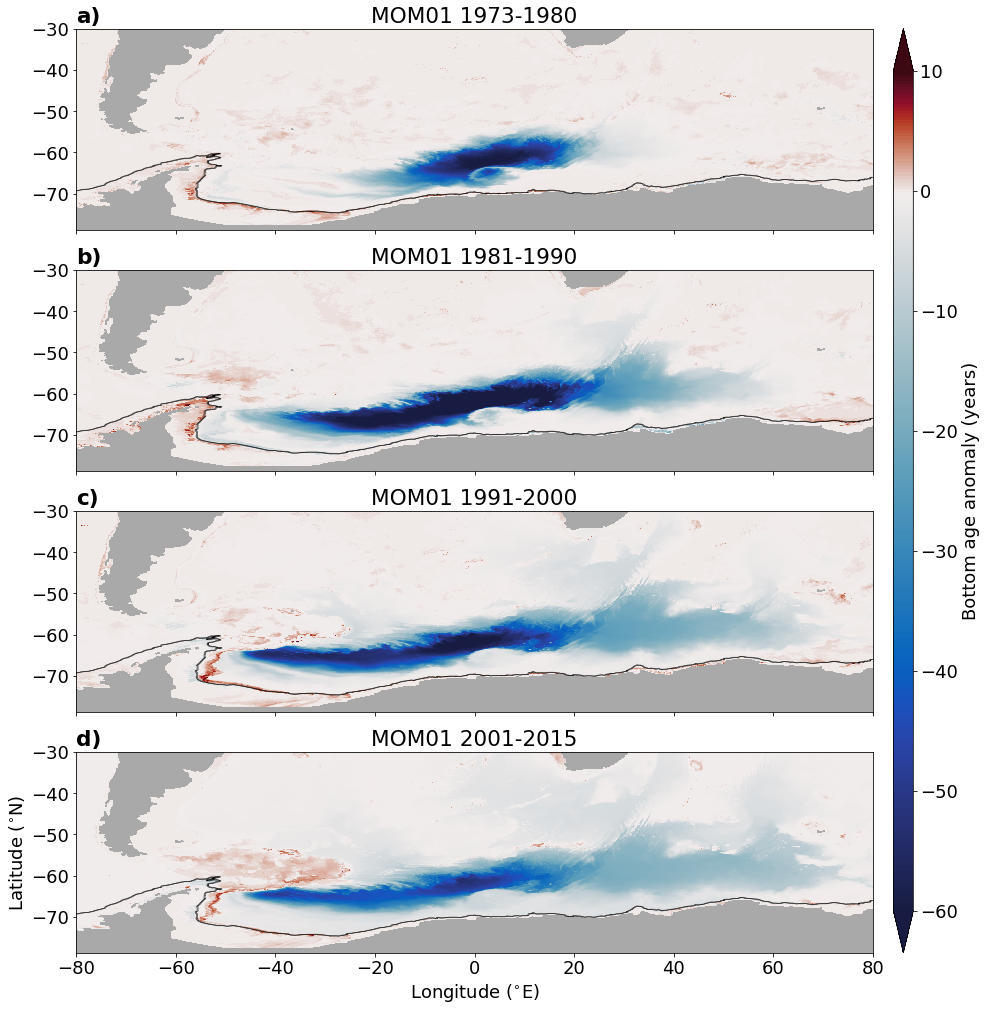

In [107]:
fig = plt.figure(figsize=(15, 17))
# Panel title
title_name = ['MOM01 1973-1980', 'MOM01 1981-1990', 'MOM01 1991-2000', 'MOM01 2001-2015']
# Subplots grid
gs  = gridspec.GridSpec(4, 2, height_ratios=[1, 1, 1, 1], width_ratios=[1, 0.025], wspace=0.05)
m1=-60
m2=10
#midpoint his should be  1 - vmax / (vmax + abs(vmin))
mp=1 - 10/(10 + 60)
orig_cmap = cmocean.balance
shifted_cmap = shiftedColorMap(orig_cmap,midpoint=mp, name='shifted')

# Define subplot, add panel title and label
def plot_land():
    ax.set_title(panel_name[ii], loc='left', fontweight='bold')    
    ax.set_xlim([-80, 80])
    ax.set_ylim([-78.7, -30])
    # Add land 
    ax.contourf(ht.xt_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2)
    ax.contour(contour_xt_ocean, contour_yt_ocean, contour_1000m, [1000],colors='k', linewidths=0.5)

for ii in range(4):
    if ii == 0:
        ax = fig.add_subplot(gs[ii])
        ax.set_title(title_name[ii])
        plot_land()
        cf = ax.pcolormesh(bottom_age_con_01.xt_ocean, bottom_age_con_01.yt_ocean, (bottom_age_pert_01[0:8].mean(dim='time')-bottom_age_con_01[0:8].mean(dim='time')), cmap=shifted_cmap, vmin=m1, vmax=m2) 
        # Masked DSW regions
#        ax.add_patch(poly1)
#        ax.add_patch(poly2)
#        ax.add_patch(poly3)
#        ax.add_patch(poly4)
    elif ii == 1:
        # Age, WIND-
        ax = fig.add_subplot(gs[ii+1])
        ax.set_title(title_name[ii])
        plot_land()
        cf = ax.pcolormesh(bottom_age_con_01.xt_ocean, bottom_age_con_01.yt_ocean, (bottom_age_pert_01[8:18].mean(dim='time')-bottom_age_con_01[8:18].mean(dim='time')), cmap=shifted_cmap, vmin=m1, vmax=m2) 
    elif ii == 2:
        # Salt, WIND+
        ax = fig.add_subplot(gs[ii+2])
        ax.set_title(title_name[ii])
        plot_land()
        cf = ax.pcolormesh(bottom_age_con_01.xt_ocean, bottom_age_con_01.yt_ocean, (bottom_age_pert_01[18:28].mean(dim='time')-bottom_age_con_01[18:28].mean(dim='time')), cmap=shifted_cmap, vmin=m1, vmax=m2) 
    elif ii == 3:
        # Salt, WIND-
        ax = fig.add_subplot(gs[ii+3])
        ax.set_title(title_name[ii])
        plot_land()
        cf = ax.pcolormesh(bottom_age_con_01.xt_ocean, bottom_age_con_01.yt_ocean, (bottom_age_pert_01[28:42].mean(dim='time')-bottom_age_con_01[28:42].mean(dim='time')), cmap=shifted_cmap, vmin=m1, vmax=m2) 
        plt.xlabel('Longitude ($^{\circ}$E)')
        plt.ylabel('Latitude ($^{\circ}$N)')
    if ii < 3:
        plt.tick_params(labelbottom=False)
        
        
# Add colorbars
cbar_ax = fig.add_subplot(gs[0:4, -1])
cbar = plt.colorbar(cf, cax=cbar_ax, fraction=0.03, pad=0.01, extend='both')
cbar.set_label('Bottom age anomaly (years)')

# Finished
save_fig = 0
if save_fig == 1:
    fig_name = 'Figure3.png'
    plt.savefig(fig_path + fig_name)


In [98]:
# topography data for plotting:
#extract the MOM model grid info - 50 and 75 vertical levels
hgrid_file ='/g/data/hh5/tmp/pas561/gfdl_nyf_1080/mom025_ocean_grid.nc'
vgrid_file ='/g/data/hh5/tmp/pas561/gfdl_nyf_1080/ocean.ncra501-520.nc'

# Extract the variables
nc = xr.open_dataset(hgrid_file) # file handle, open in read only mode
geolon_t = nc.geolon_t
geolat_t = nc.geolat_t
area_t = nc.area_t
dxt = nc.dxt
dyt = nc.dyt
kmt = nc.kmt
ht = nc.ht
print(geolon_t.shape)

ht = ht.sel(yt_ocean=lat_slice)
ht = ht.load()
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)
# make land go all the way to -90S:
land_mask_lat = ht.yt_ocean.values
land_mask_lat[0] = -90

fontsize=13

(1080, 1440)


In [103]:
NYFCntrlDir = '/g/data/v45/pas561/mom/archive/wombat_jul15b_r0/'
#this has 3 years of a wind perturbation - get a nice 3 year polynya.

Ocean_File = os.path.join(NYFCntrlDir,'output*/ocean__*.nc')
print(Ocean_File)
cntrl_025=xr.open_mfdataset(Ocean_File,engine='netcdf4').age_global
print(cntrl_025.shape)

/g/data/v45/pas561/mom/archive/wombat_jul15b_r0/output*/ocean__*.nc


AttributeError: 'Dataset' object has no attribute 'age_global'

In [72]:
NYFPertDir = '/g/data/v45/pas561/mom/archive/wombat_jul15b_r0_wp2/'

Ocean_File = os.path.join(NYFPertDir,'output*/ocean__*.nc').age_global
print Ocean_File
pert_025=xr.open_mfdataset(Ocean_File,engine='netcdf4').age_global
print pert_025.shape

/g/data3/hh5/tmp/pas561/kds75_cp_ann/ocean_*.nc
(42, 75, 1351, 3600)


In [73]:
NYFPertDir = '/g/data3/hh5/tmp/pas561/kds75_wp2/2yr/'

Ocean_File = os.path.join(NYFPertDir,'ocean_*.nc')
print(Ocean_File)
mom01_pert=xr.open_mfdataset(Ocean_File).age_global
print(mom01_pert.shape)

/g/data3/hh5/tmp/pas561/kds75_wp2/2yr/ocean_*.nc
(41, 75, 1351, 3600)


In [74]:
mom01_cntrl

<xarray.DataArray 'age_global' (time: 42, st_ocean: 75, yt_ocean: 1351,
                                xt_ocean: 3600)>
dask.array<concatenate, shape=(42, 75, 1351, 3600), dtype=float32, chunksize=(1, 75, 1351, 3600), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 10.29 10.39 10.49
  * time      (time) object 0114-09-30 21:00:00 ... 0155-07-01 15:00:00
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
    geolon_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(1351, 3600), meta=np.ndarray>
    geolat_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(1351, 3600), meta=np.ndarray>
Attributes:
    long_name:      Age (global)
    units:          yr
    valid_range:    [0.e+00 1.e+20]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_age_since_surface_contact

In [75]:
mom01_pert

<xarray.DataArray 'age_global' (time: 41, st_ocean: 75, yt_ocean: 1351,
                                xt_ocean: 3600)>
dask.array<concatenate, shape=(41, 75, 1351, 3600), dtype=float32, chunksize=(1, 75, 1351, 3600), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 10.29 10.39 10.49
  * time      (time) object 0114-09-30 21:00:00 ... 0154-07-01 15:00:00
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
    geolon_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(1351, 3600), meta=np.ndarray>
    geolat_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(1351, 3600), meta=np.ndarray>
Attributes:
    long_name:      Age (global)
    units:          yr
    valid_range:    [0.e+00 1.e+20]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_age_since_surface_contact

In [76]:
# select out bottom values:
depth_array = mom01_cntrl * 0 + mom01_cntrl.st_ocean
max_depth = depth_array.max(dim = 'st_ocean', skipna= True)

In [77]:
max_depth

<xarray.DataArray (time: 42, yt_ocean: 1351, xt_ocean: 3600)>
dask.array<_nanmax_skip-aggregate, shape=(42, 1351, 3600), dtype=float64, chunksize=(1, 1351, 3600), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 10.29 10.39 10.49
  * time      (time) object 0114-09-30 21:00:00 ... 0155-07-01 15:00:00
    geolon_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(1351, 3600), meta=np.ndarray>
    geolat_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(1351, 3600), meta=np.ndarray>

In [78]:
bottom_age_con_01 = mom01_cntrl.where(depth_array.st_ocean >= max_depth)
bottom_age_con_01 = bottom_age_con_01.sum(dim = 'st_ocean')
bottom_age_con_01 = bottom_age_con_01.load()
bottom_age_con_01

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


<xarray.DataArray 'age_global' (time: 42, yt_ocean: 1351, xt_ocean: 3600)>
array([[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.8491776 ,  1.6047494 ,  2.8658533 , ...,  0.08914887,
          0.        ,  0.25451303],
        [ 0.90299606,  1.9362854 ,  6.2781296 , ...,  0.        ,
          0.        ,  0.28487805],
        [ 0.9090438 ,  1.8975666 , 19.880257  , ...,  0.        ,
          0.        ,  0.31658715]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
...
        [ 0.83281004,  1.6964583 ,  2.8199894 , ...,  0.09397168,
          0.        ,  0.26079375],
        [ 0.79916894,  1.9263362 ,  7.2586875 , ...,  0.        ,
          0.        ,  0.26917198],
        [ 0.8340571 ,  1.895227  , 19.396389  , ...,  0.        ,
          0.        ,  0.2940737 ]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.5329892 ,  1.1880119 ,  2.252926  , ...,  0.04327459,
          0.        ,  0.15126047],
        [ 0.62418926,  1.5102075 ,  7.1959777 , ...,  0.        ,
          0.        ,  0.19551714],
        [ 0.6926467 ,  1.5348808 , 21.23313   , ...,  0.        ,
          0.        ,  0.25053102]]], dtype=float32)
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 10.29 10.39 10.49
  * time      (time) object 0114-09-30 21:00:00 ... 0155-07-01 15:00:00
    geolon_t  (yt_ocean, xt_ocean) float32 -280.0 -279.9 -279.8 ... 79.85 79.95
    geolat_t  (yt_ocean, xt_ocean) float32 -81.11 -81.11 -81.11 ... 10.49 10.49

In [79]:
bottom_age_pert_01 = mom01_pert.where(depth_array.st_ocean >= max_depth)
bottom_age_pert_01 = bottom_age_pert_01.sum(dim = 'st_ocean')
bottom_age_pert_01 = bottom_age_pert_01.load()
bottom_age_pert_01

<xarray.DataArray 'age_global' (time: 41, yt_ocean: 1351, xt_ocean: 3600)>
array([[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.8538053 ,  1.645129  ,  2.917503  , ...,  0.07495838,
          0.        ,  0.250686  ],
        [ 0.9148625 ,  1.9865134 ,  6.6529245 , ...,  0.        ,
          0.        ,  0.27423   ],
        [ 0.92000675,  1.9140369 , 18.60519   , ...,  0.        ,
          0.        ,  0.30418053]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
...
        [ 0.75823605,  1.5434391 ,  2.6806257 , ...,  0.08573375,
          0.        ,  0.2711418 ],
        [ 0.8444815 ,  1.7672861 ,  7.6845164 , ...,  0.        ,
          0.        ,  0.33370697],
        [ 0.8863696 ,  1.7853172 , 20.863182  , ...,  0.        ,
          0.        ,  0.3766419 ]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.85804415,  1.6218786 ,  2.9299967 , ...,  0.1108689 ,
          0.        ,  0.40805468],
        [ 1.1862229 ,  2.3274097 ,  7.705515  , ...,  0.        ,
          0.        ,  0.5774609 ],
        [ 1.252481  ,  2.179425  , 19.479202  , ...,  0.        ,
          0.        ,  0.64792466]]], dtype=float32)
Coordinates:
  * time      (time) object 0114-09-30 21:00:00 ... 0154-07-01 15:00:00
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 10.29 10.39 10.49
    geolon_t  (yt_ocean, xt_ocean) float32 -280.0 -279.9 -279.8 ... 79.85 79.95
    geolat_t  (yt_ocean, xt_ocean) float32 -81.11 -81.11 -81.11 ... 10.49 10.49

In [82]:
bottom_age_pert_01.to_netcdf('/g/data/hh5/tmp/pas561/kds75_wp2/2yr/bot_age.nc')

In [84]:
bottom_age_con_01.to_netcdf('/g/data/hh5/tmp/pas561/kds75_cp_ann/bot_age.nc')

In [2]:
#load gmoc in rho space
#NYFCntrlDir = '/g/data3/hh5/tmp/cosima/mom01v5/kds75_cp/'
#NYFPertDir = '/g/data3/hh5/tmp/pas561/kds75_wp2/2yr/'
NYFCntrlDir = '/g/data3/hh5/tmp/pas561/kds75_cp_ann/'
NYFPertDir = '/g/data3/hh5/tmp/pas561/kds75_wp2/2yr/'

#Ocean_File = os.path.join(NYFPertDir,'output*/ocean.nc')
#print Ocean_File
#pert=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
#print pert.ty_trans_rho.shape

vgrid_file ='/g/data1/v45/pas561/mom/archive/VertOverturn/kds75.uvwt.230-257.ncra.nc'
nc = Dataset(vgrid_file, mode='r') # file handle, open in read only mode
yt_ocean2 = nc.variables['yt_ocean'][:]
yu_ocean2 = nc.variables['yu_ocean'][:]
xt_ocean2 = nc.variables['xt_ocean'][:]
xu_ocean2 = nc.variables['xu_ocean'][:]
st_ocean2 = nc.variables['st_ocean'][:]
#dzt2 = nc.variables['dzt'][:]
#potrho = nc.variables['potrho'][:]
nc.close() # close the file
#print potrho.shape
#print yu_ocean.shape


#fix this to a 12 month average
nc = Dataset('/g/data3/hh5/tmp/pas561/kds75_cp/dzt.9month.nc', mode='r') # file handle, open in read only mode
dzt2 = nc.variables['dzt'][:]
nc.close() # close the file
#print dzt.shape

hgrid_file ='/g/data1/v45/pas561/mom/archive/VertOverturn/mom01_unmasked_ocean_grid.nc'
# Extract the variables
nc = Dataset(hgrid_file, mode='r') # file handle, open in read only mode
geolon_t2 = nc.variables['geolon_t'][:]
geolat_t2 = nc.variables['geolat_t'][:]
nc.close() # close the file


In [3]:
Ocean_File = os.path.join(NYFCntrlDir,'ocean_*.nc')
print(Ocean_File)
mom01_cntrl=xr.open_mfdataset(Ocean_File).age_global
print(mom01_cntrl.shape)

Ocean_File = os.path.join(NYFPertDir,'ocean_*.nc')
print(Ocean_File)
mom01_pert=xr.open_mfdataset(Ocean_File).age_global
print(mom01_pert.shape)


/g/data3/hh5/tmp/pas561/kds75_cp_ann/ocean_*.nc


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/xarray/coding/times.py:419: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  self.use_cftime)


[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.2s
[########################################] | 100

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/xarray/coding/times.py:419: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  self.use_cftime)


[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.2s
(29, 75, 1351, 3600)


In [4]:
print(st_ocean2.shape)
print(st_ocean2[0:46])
print(st_ocean2[46:66])
print(st_ocean2[66:75])
print(dzt2.shape)

(75,)
[5.41280765e-01 1.68073468e+00 2.93995265e+00 4.33152149e+00
 5.86935042e+00 7.56880992e+00 9.44688496e+00 1.15223444e+01
 1.38159279e+01 1.63505526e+01 1.91515408e+01 2.22468718e+01
 2.56674591e+01 2.94474571e+01 3.36245984e+01 3.82405659e+01
 4.33414022e+01 4.89779610e+01 5.52064020e+01 6.20887357e+01
 6.96934198e+01 7.80960121e+01 8.73798840e+01 9.76369969e+01
 1.08968745e+02 1.21486866e+02 1.35314420e+02 1.50586834e+02
 1.67453006e+02 1.86076460e+02 2.06636535e+02 2.29329581e+02
 2.54370129e+02 2.81991982e+02 3.12449164e+02 3.46016618e+02
 3.82990565e+02 4.23688336e+02 4.68447515e+02 5.17624173e+02
 5.71589915e+02 6.30727513e+02 6.95424821e+02 7.66066799e+02
 8.43025513e+02 9.26648199e+02]
[1017.24370768 1115.06797498 1220.30949515 1333.07609258 1453.38443981
 1581.15373743 1716.20465096 1858.26402924 2006.97519805 2161.91288246
 2322.60123414 2488.53315123 2659.18911348 2834.05406813 3012.63138121
 3194.45338659 3379.08852049 3566.14536241 3755.27409766 3946.16599027]
[4138.

In [5]:
#depth average between 1000-4000m and below 4000m, Fig 3 of Purkey et al., 2016.
#calculate linear ocean warming trends spanning 1981 to 2016

#depth integrate from 1000-4000 and 4000:

print(st_ocean2.shape)
print(st_ocean2[0:46])
print(st_ocean2[46:66])
print(st_ocean2[66:75])

print(mom01_pert.shape)
mom01_pA_0to1=np.zeros((mom01_pert.shape[0],mom01_pert.shape[2],mom01_pert.shape[3]))
mom01_pA_1to4=np.zeros((mom01_pert.shape[0],mom01_pert.shape[2],mom01_pert.shape[3]))
mom01_pA_4to6=np.zeros((mom01_pert.shape[0],mom01_pert.shape[2],mom01_pert.shape[3]))
print(mom01_pA_1to4.shape)

for t in range(mom01_pert.shape[0]):
    print(t)
    
    mom01_pA_0to1[t,:,:]=np.sum(mom01_pert[t,0:46,:,:].load()*dzt2[0,0:46,0:1351,:],axis=0)/np.sum(dzt2[0,0:46,0:1351,:],axis=0)
    mom01_pA_1to4[t,:,:]=np.sum(mom01_pert[t,46:66,:,:].load()*dzt2[0,46:66,0:1351,:],axis=0)/np.sum(dzt2[0,46:66,0:1351,:],axis=0)
    mom01_pA_4to6[t,:,:]=np.sum(mom01_pert[t,66:75,:,:].load()*dzt2[0,66:75,0:1351,:],axis=0)/np.sum(dzt2[0,66:75,0:1351,:],axis=0)
    
of=os.path.join('/g/data3/hh5/tmp/pas561/kds75_wp2/2yr/','pA_0to1.npy')
a=np.save(of,mom01_pA_0to1)
of=os.path.join('/g/data3/hh5/tmp/pas561/kds75_wp2/2yr/','pA_1to4.npy')
a=np.save(of,mom01_pA_1to4)
of=os.path.join('/g/data3/hh5/tmp/pas561/kds75_wp2/2yr/','pA_4to6.npy')
a=np.save(of,mom01_pA_4to6)


(75,)
[5.41280765e-01 1.68073468e+00 2.93995265e+00 4.33152149e+00
 5.86935042e+00 7.56880992e+00 9.44688496e+00 1.15223444e+01
 1.38159279e+01 1.63505526e+01 1.91515408e+01 2.22468718e+01
 2.56674591e+01 2.94474571e+01 3.36245984e+01 3.82405659e+01
 4.33414022e+01 4.89779610e+01 5.52064020e+01 6.20887357e+01
 6.96934198e+01 7.80960121e+01 8.73798840e+01 9.76369969e+01
 1.08968745e+02 1.21486866e+02 1.35314420e+02 1.50586834e+02
 1.67453006e+02 1.86076460e+02 2.06636535e+02 2.29329581e+02
 2.54370129e+02 2.81991982e+02 3.12449164e+02 3.46016618e+02
 3.82990565e+02 4.23688336e+02 4.68447515e+02 5.17624173e+02
 5.71589915e+02 6.30727513e+02 6.95424821e+02 7.66066799e+02
 8.43025513e+02 9.26648199e+02]
[1017.24370768 1115.06797498 1220.30949515 1333.07609258 1453.38443981
 1581.15373743 1716.20465096 1858.26402924 2006.97519805 2161.91288246
 2322.60123414 2488.53315123 2659.18911348 2834.05406813 3012.63138121
 3194.45338659 3379.08852049 3566.14536241 3755.27409766 3946.16599027]
[4138.

In [6]:
#depth average between 1000-4000m and below 4000m, Fig 3 of Purkey et al., 2016.
#calculate linear ocean warming trends spanning 1981 to 2016

#depth integrate from 1000-4000 and 4000:

print(st_ocean2.shape)
print(st_ocean2[0:46])
print(st_ocean2[46:66])
print(st_ocean2[66:75])

print(mom01_cntrl.shape)
mom01_cA_0to1=np.zeros((mom01_cntrl.shape[0],mom01_cntrl.shape[2],mom01_cntrl.shape[3]))
mom01_cA_1to4=np.zeros((mom01_cntrl.shape[0],mom01_cntrl.shape[2],mom01_cntrl.shape[3]))
mom01_cA_4to6=np.zeros((mom01_cntrl.shape[0],mom01_cntrl.shape[2],mom01_cntrl.shape[3]))
print(mom01_cA_1to4.shape)

for t in range(mom01_cntrl.shape[0]):
    print(t)
    
    mom01_cA_0to1[t,:,:]=np.sum(mom01_cntrl[t,0:46,:,:].load()*dzt2[0,0:46,0:1351,:],axis=0)/np.sum(dzt2[0,0:46,0:1351,:],axis=0)
    mom01_cA_1to4[t,:,:]=np.sum(mom01_cntrl[t,46:66,:,:].load()*dzt2[0,46:66,0:1351,:],axis=0)/np.sum(dzt2[0,46:66,0:1351,:],axis=0)
    mom01_cA_4to6[t,:,:]=np.sum(mom01_cntrl[t,66:75,:,:].load()*dzt2[0,66:75,0:1351,:],axis=0)/np.sum(dzt2[0,66:75,0:1351,:],axis=0)
    
of=os.path.join('/g/data3/hh5/tmp/pas561/kds75_cp/','cA_0to1.npy')
a=np.save(of,mom01_cA_0to1)
of=os.path.join('/g/data3/hh5/tmp/pas561/kds75_cp/','cA_1to4.npy')
a=np.save(of,mom01_cA_1to4)
of=os.path.join('/g/data3/hh5/tmp/pas561/kds75_cp/','cA_4to6.npy')
a=np.save(of,mom01_cA_4to6)


(75,)
[5.41280765e-01 1.68073468e+00 2.93995265e+00 4.33152149e+00
 5.86935042e+00 7.56880992e+00 9.44688496e+00 1.15223444e+01
 1.38159279e+01 1.63505526e+01 1.91515408e+01 2.22468718e+01
 2.56674591e+01 2.94474571e+01 3.36245984e+01 3.82405659e+01
 4.33414022e+01 4.89779610e+01 5.52064020e+01 6.20887357e+01
 6.96934198e+01 7.80960121e+01 8.73798840e+01 9.76369969e+01
 1.08968745e+02 1.21486866e+02 1.35314420e+02 1.50586834e+02
 1.67453006e+02 1.86076460e+02 2.06636535e+02 2.29329581e+02
 2.54370129e+02 2.81991982e+02 3.12449164e+02 3.46016618e+02
 3.82990565e+02 4.23688336e+02 4.68447515e+02 5.17624173e+02
 5.71589915e+02 6.30727513e+02 6.95424821e+02 7.66066799e+02
 8.43025513e+02 9.26648199e+02]
[1017.24370768 1115.06797498 1220.30949515 1333.07609258 1453.38443981
 1581.15373743 1716.20465096 1858.26402924 2006.97519805 2161.91288246
 2322.60123414 2488.53315123 2659.18911348 2834.05406813 3012.63138121
 3194.45338659 3379.08852049 3566.14536241 3755.27409766 3946.16599027]
[4138.

In [9]:
of=os.path.join('/g/data3/hh5/tmp/pas561/kds75_cp/','cA_0to1.npy')
mom01_cA_0to1=np.load(of)

of=os.path.join('/g/data3/hh5/tmp/pas561/kds75_cp/','cA_1to4.npy')
mom01_cA_1to4=np.load(of)

of=os.path.join('/g/data3/hh5/tmp/pas561/kds75_cp/','cA_4to6.npy')
mom01_cA_4to6=np.load(of)  

print(mom01_cA_1to4.shape)
print(mom01_cA_4to6.shape)

of=os.path.join(NYFPertDir,'pA_0to1.npy')
mom01_pA_0to1=np.load(of)

of=os.path.join(NYFPertDir,'pA_1to4.npy')
mom01_pA_1to4=np.load(of)

of=os.path.join(NYFPertDir,'pA_4to6.npy')
mom01_pA_4to6=np.load(of)  

print(mom01_pA_1to4.shape)
print(mom01_pA_4to6.shape)


(29, 1351, 3600)
(29, 1351, 3600)
(29, 1351, 3600)
(29, 1351, 3600)


In [13]:
#cyrs=np.arange(1970,2017,1)
pyrs=np.arange(1973,1973+29,1)

#calc linear trend in C/s since 1981-2000 (8 years from 1973) 
print(pyrs)
print(pyrs[8:28])
#print(pyrs[28:44])
pyrs.shape

[1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986
 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000
 2001]
[1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994
 1995 1996 1997 1998 1999 2000]


(29,)

In [15]:
#calc dA/dt
#cyrs=np.arange(1970,2017,1)
pyrs=np.arange(1973,1973+29,1)

#calc linear trend in C/s since 1981-2000 (8 years from 1973) 
#print cyrs[11:31]
print(pyrs[8:28])


mom01_tr81to00_pA_0to1=np.zeros((mom01_cntrl.shape[2],mom01_cntrl.shape[3]))
mom01_tr81to00_cA_0to1=np.zeros((mom01_cntrl.shape[2],mom01_cntrl.shape[3]))
mom01_tr81to00_pA_1to4=np.zeros((mom01_cntrl.shape[2],mom01_cntrl.shape[3]))
mom01_tr81to00_cA_1to4=np.zeros((mom01_cntrl.shape[2],mom01_cntrl.shape[3]))
mom01_tr81to00_pA_4to6=np.zeros((mom01_cntrl.shape[2],mom01_cntrl.shape[3]))
mom01_tr81to00_cA_4to6=np.zeros((mom01_cntrl.shape[2],mom01_cntrl.shape[3]))


for j in range(0,mom01_cntrl.shape[2]):
    #print j
    
    mom01_tr81to00_pA_0to1[j,:]=np.polyfit(range(20), mom01_pA_0to1[8:28,j,:],1)[0,:]
    mom01_tr81to00_cA_0to1[j,:]=np.polyfit(range(20), mom01_cA_0to1[8:28,j,:],1)[0,:]
     
    mom01_tr81to00_pA_1to4[j,:]=np.polyfit(range(20), mom01_pA_1to4[8:28,j,:],1)[0,:]
    mom01_tr81to00_cA_1to4[j,:]=np.polyfit(range(20), mom01_cA_1to4[8:28,j,:],1)[0,:]
    
    mom01_tr81to00_pA_4to6[j,:]=np.polyfit(range(20), mom01_pA_4to6[8:28,j,:],1)[0,:]
    mom01_tr81to00_cA_4to6[j,:]=np.polyfit(range(20), mom01_cA_4to6[8:28,j,:],1)[0,:]    
    

[1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994
 1995 1996 1997 1998 1999 2000]


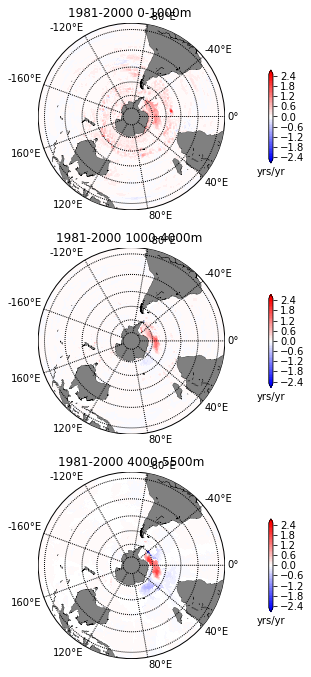

In [21]:
plt.figure(figsize(12.5,9.5))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
#plt.suptitle('(1991-2000)-(1981-1990) Decadal Temp Anom')

clev = np.arange(-2.5,2.6,.1)

plt.subplot(3,1,1)
map = Basemap(projection='spstere',boundinglat=-1,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,15.))
map.drawmeridians(np.arange(-160.,181.,40.),labels=[True,True,True,True])
X, Y = map(geolon_t2[0:1351,:],geolat_t2[0:1351,:]) 
#cntrl starts 1971, pert in 1973.
#cntrl Tdim ends in 1980, normal starts 1981
p1=map.contourf(X,Y,mom01_tr81to00_pA_0to1-mom01_tr81to00_cA_0to1, cmap=plt.cm.bwr, levels=clev, extend='both') #CMRmap_r, gist_stern_r
cb=plt.colorbar(orientation='vertical',shrink = 0.5)
cb.ax.set_xlabel('yrs/yr')
#clev3 = np.arange(1000,5001,1000)
#map.contour(X,Y,ht[0:500,:],levels=clev3,colors='k',linewidths=1)
plt.title('1981-2000 0-1000m ')


plt.subplot(3,1,2)
map = Basemap(projection='spstere',boundinglat=-1,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,15.))
map.drawmeridians(np.arange(-160.,181.,40.),labels=[True,True,True,True])
X, Y = map(geolon_t2[0:1351,:],geolat_t2[0:1351,:]) 
#cntrl starts 1971, pert in 1973.
#cntrl Tdim ends in 1980, normal starts 1981
p1=map.contourf(X,Y,mom01_tr81to00_pA_1to4-mom01_tr81to00_cA_1to4, cmap=plt.cm.bwr, levels=clev, extend='both') #CMRmap_r, gist_stern_r
cb=plt.colorbar(orientation='vertical',shrink = 0.5)
cb.ax.set_xlabel('yrs/yr')
#clev3 = np.arange(1000,5001,1000)
#map.contour(X,Y,ht[0:500,:],levels=clev3,colors='k',linewidths=1)
plt.title('1981-2000 1000-4000m ')

#ax3 = plt.axes([0.99,0.68,0.015,0.25])
#cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
#cb.ax.set_xlabel('$W/m^2$')


plt.subplot(3,1,3)
map = Basemap(projection='spstere',boundinglat=-1,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,15.))
map.drawmeridians(np.arange(-160.,181.,40.),labels=[True,True,True,True])
X, Y = map(geolon_t2[0:1351,:],geolat_t2[0:1351,:]) 
#cntrl starts 1971, pert in 1973.
#cntrl Tdim ends in 1980, normal starts 1981
p1=map.contourf(X,Y,mom01_tr81to00_pA_4to6-mom01_tr81to00_cA_4to6,cmap=plt.cm.bwr, levels=clev, extend='both') #CMRmap_r, gist_stern_r
cb=plt.colorbar(orientation='vertical',shrink = 0.5)
cb.ax.set_xlabel('yrs/yr')
#cb.ax.set_xlabel('C')
#clev3 = np.arange(1000,5001,1000)
#map.contour(X,Y,ht[0:500,:],levels=clev3,colors='k',linewidths=1)
plt.title('1981-2000 4000-5500m')


plt.tight_layout()